## Facial Attribute Detection Using Convolutional Neural Networks

### Preprocessing

**Team Members**   
Sike Ogieva and Lee Mabhena  

Dataset is sourced from:   
https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv   

---


In [9]:
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image
from sklearn.model_selection import train_test_split

---

**Load In The Dataset**

The dataset contains 40 labels and over 200,000 images. The initial stage involves combining the dataset into tfrecords. Why use tfrecords?

TFRecords: TFRecords is a binary file format for storing data. Using TFRecords has several advantages, especially when working with large datasets like ours:

Efficiency: TFRecords store data in a sequence of binary strings, which takes less space on disk and can be read more efficiently from disk, especially useful for large datasets.

Performance: Data in a TFRecord format can be read quickly, which is crucial for training deep learning models efficiently. TensorFlow is optimized to read from TFRecords, enabling faster input pipelines compared to reading data from other file formats.

Scalability: TFRecords support a large amount of data in a single file, which is beneficial for processing and managing large datasets. It also supports distributed training by splitting data easily across multiple machines.

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [3]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [4]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [5]:
def serialize_example(image, features):
    feature = {
        'image': _bytes_feature(image),
        'features': tf.train.Feature(float_list=tf.train.FloatList(value=features))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [6]:
# Create a tf records and save it to a file
def create_tfrecord(csv_path, images_folder, output_path):
    df = pd.read_csv(csv_path)
    df.replace(-1, 0, inplace=True)
    feature_columns = df.columns.tolist()
    feature_columns.remove('image_id')  # Remove the image_id from features

    with tf.io.TFRecordWriter(output_path) as writer:
        for _, row in df.iterrows():
            image_path = os.path.join(images_folder, f"{row['image_id']}")
            if not os.path.exists(image_path):
                continue
            image = Image.open(image_path)
            image_bytes = io.BytesIO()
            image.save(image_bytes, format='JPEG')
            image_bytes = image_bytes.getvalue()

            features = row[feature_columns].values.astype(float)
            example = serialize_example(image_bytes, features)
            writer.write(example)

In [7]:
labels = "archive/list_attr_celeba.csv"
images = 'archive/img_align_celeba/img_align_celeba'

In [10]:
# Create tfrecord named output
create_tfrecord(labels, images, 'output.tfrecords')

Code to read and parse tf records

In [11]:
def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'features': tf.io.FixedLenFeature([40], tf.float32)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def decode_image_and_resize(features):
    image = tf.image.decode_jpeg(features['image'], channels=3)
    image = tf.image.resize(image, [150, 150])  # (178, 218) Resize to the input size required by the model
    return image, features['features']

def load_dataset(tfrecord_file, start_index, end_index):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.enumerate().filter(lambda idx, _: idx >= start_index and idx < end_index)
    dataset = dataset.map(lambda idx, data: parse_tfrecord(data))
    dataset = dataset.map(decode_image_and_resize)
    return dataset

In [12]:
def load_dataset(tfrecord_file, start_index, end_index):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.enumerate().filter(lambda idx, _: idx >= start_index and idx < end_index)
    dataset = dataset.map(lambda idx, data: parse_tfrecord(data))
    dataset = dataset.map(decode_image_and_resize)
    return dataset

def get_dataset_size(file_paths):
    count = 0
    corrupted = 0
    dataset = tf.data.TFRecordDataset(file_paths)
    for record in dataset:
        try:
            # Attempt to parse the record
            parsed_record = tf.io.parse_single_example(record, {
                'image': tf.io.FixedLenFeature([], tf.string),
                'features': tf.io.FixedLenFeature([40], tf.float32)
            })
            count += 1
        except tf.errors.DataLossError:
            corrupted +=1
    print("corrupted:", corrupted)
    return count

Check the integrity of the tfrecord, whether all the images and labels were written successfully and print a single image just for verification.

In [13]:
print(get_dataset_size('output.tfrecords'))

0
202599


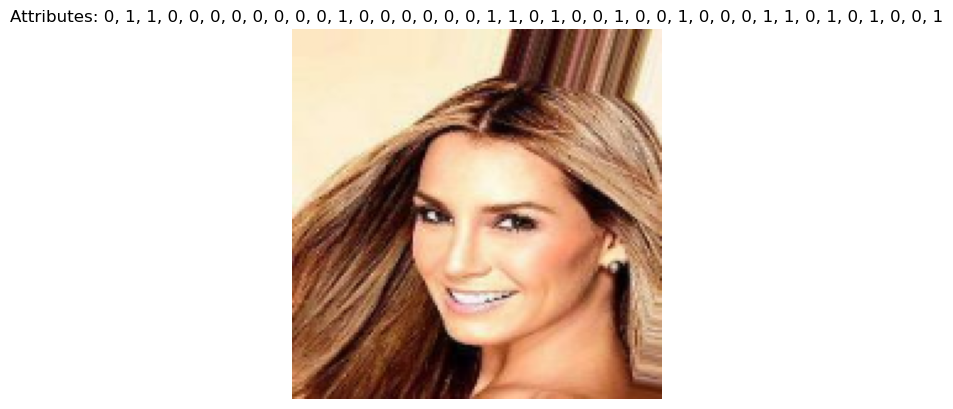

In [14]:
# Load a single entry from the dataset
def load_single_example(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.map(decode_image_and_resize)
    for image, features in dataset.take(1):  # Take one example
        return image.numpy(), features.numpy()  # Convert tensors to numpy arrays for display

# Display the image and labels
def display_image_and_labels(image, labels):
    plt.imshow(image / 255.0)  # Normalize and display the image
    plt.title("Attributes: " + ", ".join([str(int(label)) for label in labels]))
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage
image, labels = load_single_example('output.tfrecords')
display_image_and_labels(image, labels)

---

**Split And Store The Dataset**

Given that this is a massive dataset where using just 20_000 training samples took over 8 hours for just 10 epochs, we will use only 30_000 samples from the available 202_599, with 20_000 for training, and 10_000 each for validation and testing.

The authors of the dataset recommend the ranges 0 - 162770 for training, 162771, 182637 for validation and remaining for testing. We use a subset from each of those ranges.

In [15]:
train_dataset = load_dataset('output.tfrecords', 0, 20000) # 0 - 162770
validation_dataset = load_dataset('output.tfrecords', 162771, 167771) # 162771, 182637
test_dataset = load_dataset('output.tfrecords', 182638, 187638) # 182638, 202599

---

**Exploratory Analysis**

Now, we print display basic features of the dataset, visualise some of the images and check for null values and class imbalances.

In [18]:
# Print the shape of the dataset, it has 202599 rows and 41 columns
dataset = pd.read_csv("archive/list_attr_celeba.csv") 
dataset.shape

(202599, 41)

In [19]:
# Display the first few rows of the DataFrame to get a quick overview
print("First few rows of the dataset:")
print(dataset.head())

# Get a concise summary of the DataFrame, including the number of non-null values in each column
print("\nDataset summary:")
print(dataset.info())

# Display basic statistical details like percentile, mean, std etc. of a data frame's numeric columns
print("\nBasic statistical details:")
print(dataset.describe())

# Check for missing values in each column
print("\nMissing values in each column:")
print(dataset.isnull().sum())

# Display the names of the columns in the DataFrame
print("\nColumn names:")
print(dataset.columns)

First few rows of the dataset:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  We

Investigating class imbalance

In [30]:
# Total number of samples in each dataset slice
total_train_samples = 20000
total_validation_samples = 167771 - 162771
total_test_samples = 187638 - 182638

def calculate_label_distribution(dataset):
    label_sums = np.zeros(40)
    # Iterate over each batch in the dataset
    for _, labels in dataset:
        # Sum up the labels in the batch
        label_sums += np.array(labels)
    return label_sums

def calculate_percentages(label_counts, total_samples):
    # Calculate the percentage of positive labels for each label
    percentages = (label_counts / total_samples) * 100
    return percentages


train_label_distribution = calculate_label_distribution(train_dataset)
validation_label_distribution = calculate_label_distribution(validation_dataset)
test_label_distribution = calculate_label_distribution(test_dataset)

train_percentages = calculate_percentages(train_label_distribution, total_train_samples)
validation_percentages = calculate_percentages(validation_label_distribution, total_validation_samples)
test_percentages = calculate_percentages(test_label_distribution, total_test_samples)

In [31]:
def plot_label_distribution(data_percentages, feature_columns):
    fig, axes = plt.subplots(8, 5, figsize=(20, 32))  

    for i, percentage in enumerate(data_percentages):
        # Locate the position in the grid
        row = i // 5
        col = i % 5
        ax = axes[row, col]  # Access the subplot position
        
        # Plotting only on the ax specified
        ax.bar(['Negative', 'Positive'], [100 - percentage, percentage], color=['red', 'green'])
        ax.set_ylim(0, 100)  
        ax.set_title(feature_columns[i])
        ax.set_ylabel('% of Samples')
        ax.set_xticks(['Negative', 'Positive'])  

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Class distribution in train dataset


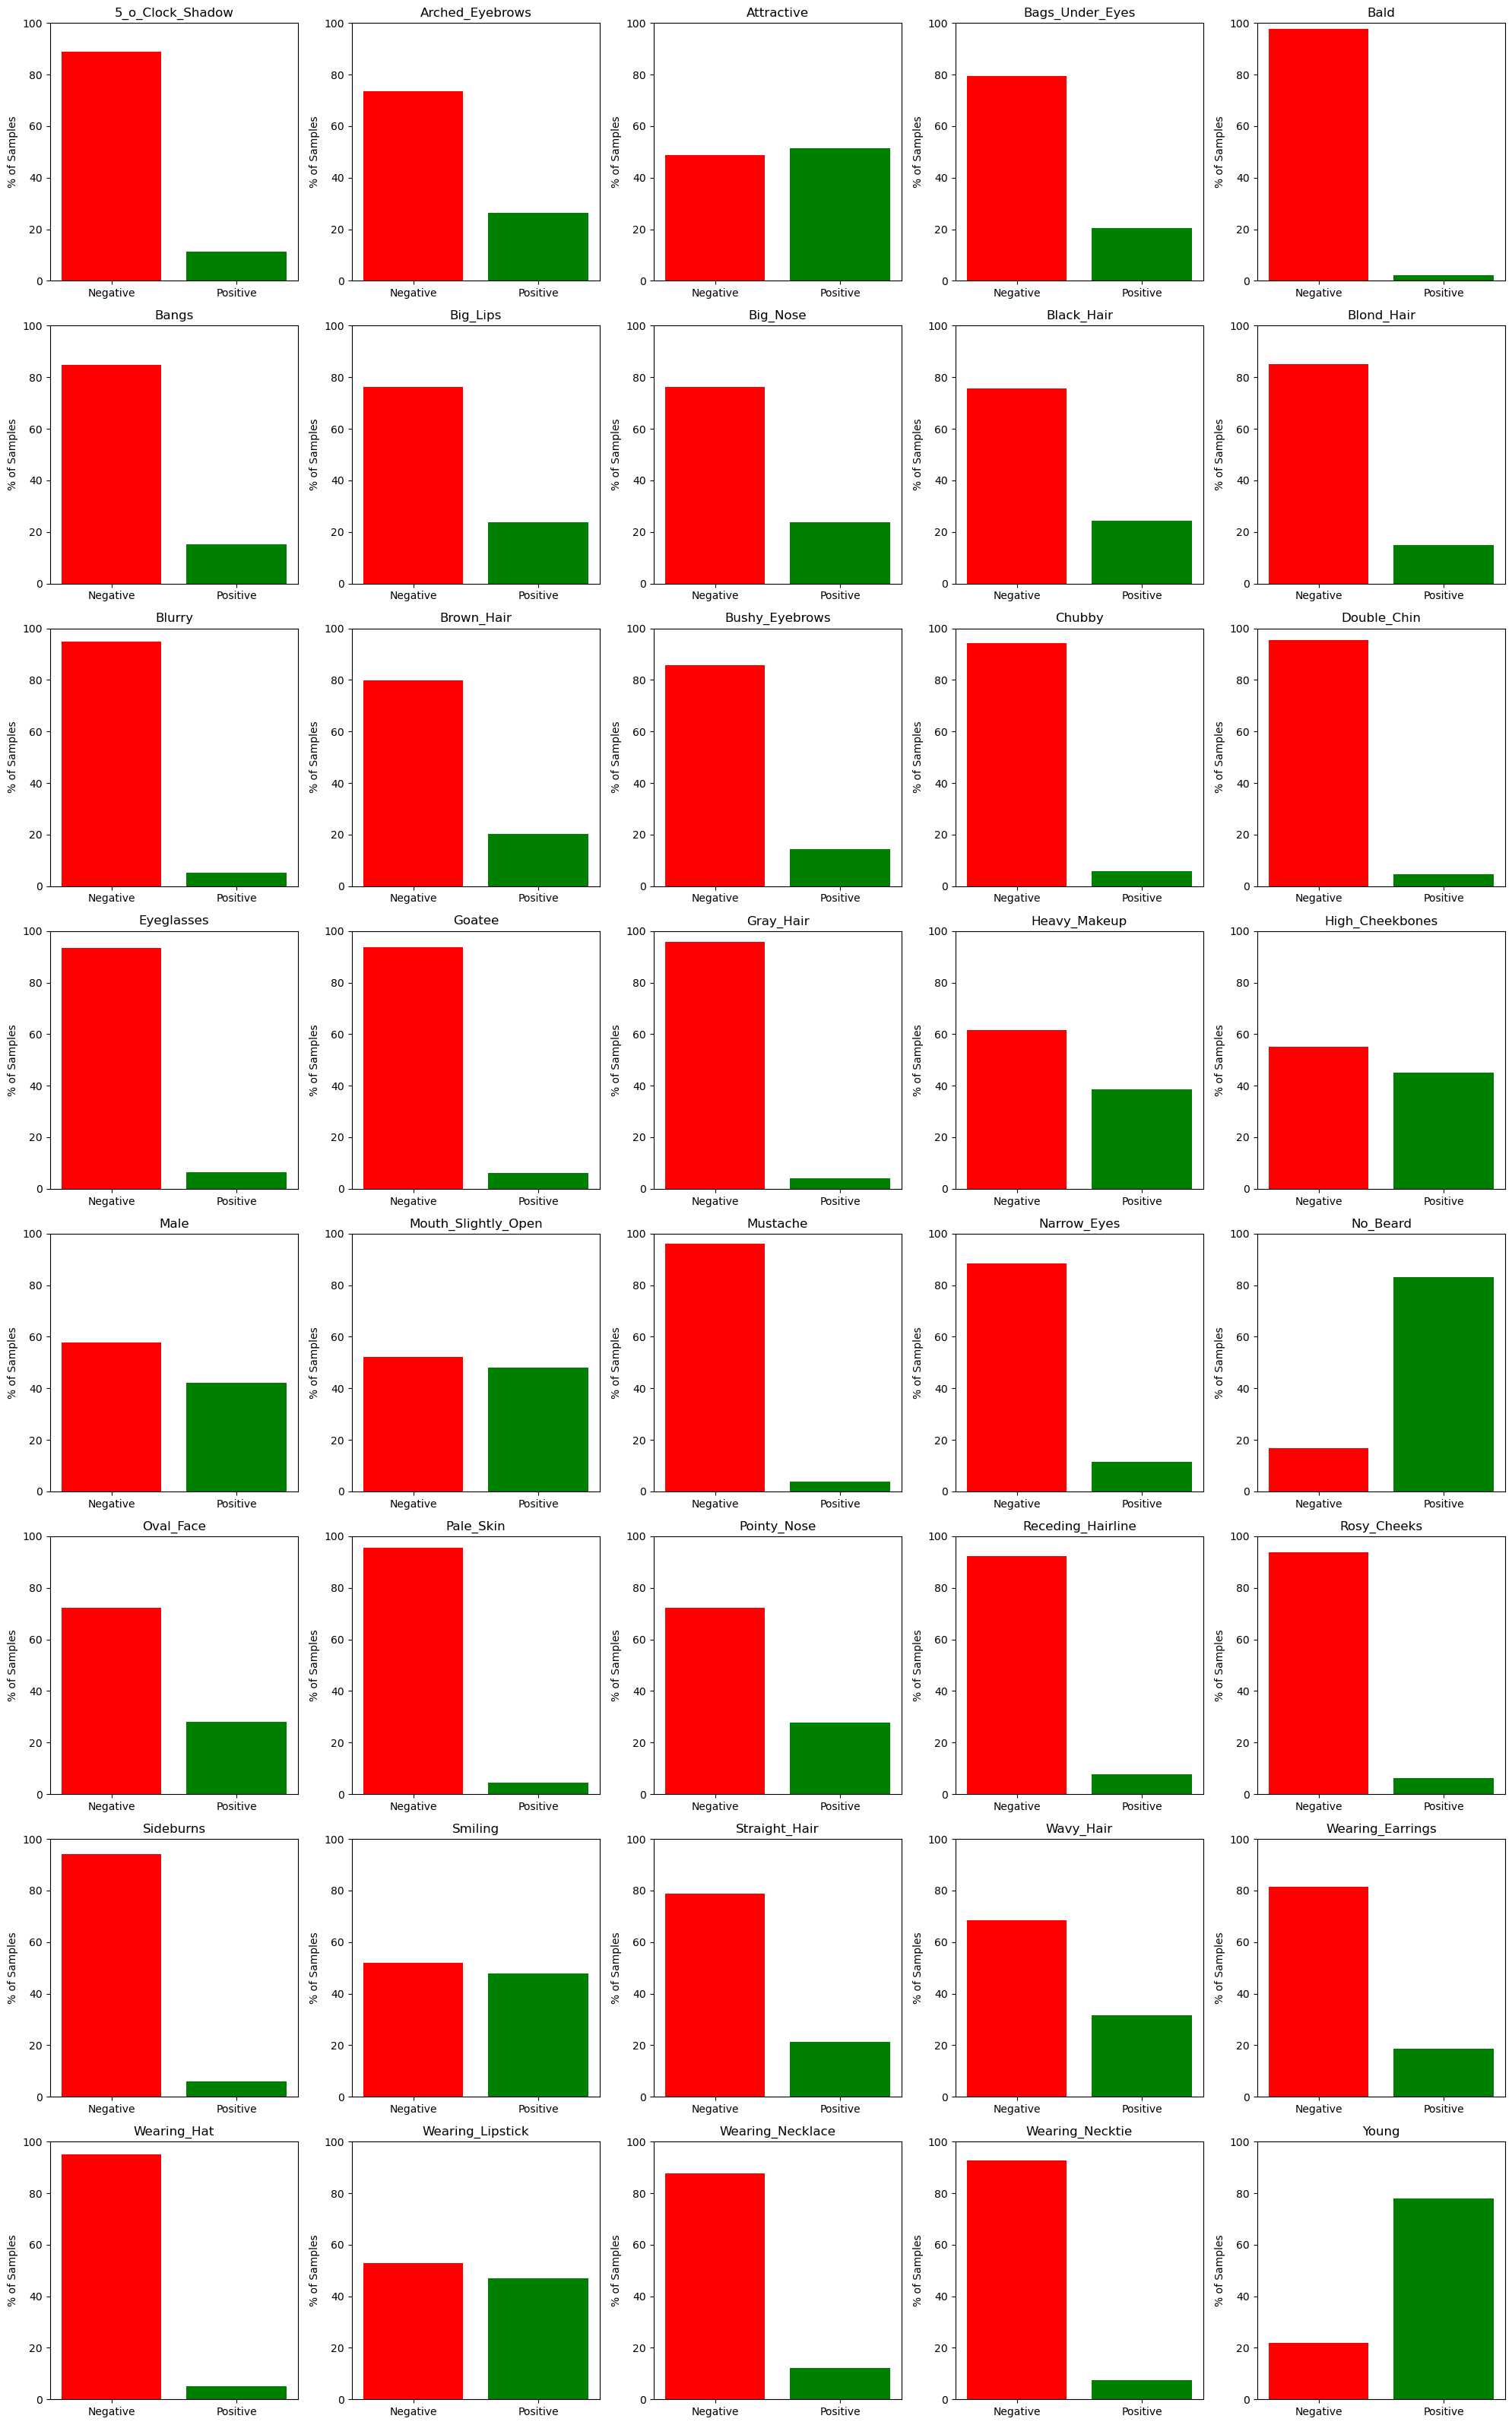

Class distribution in validation dataset


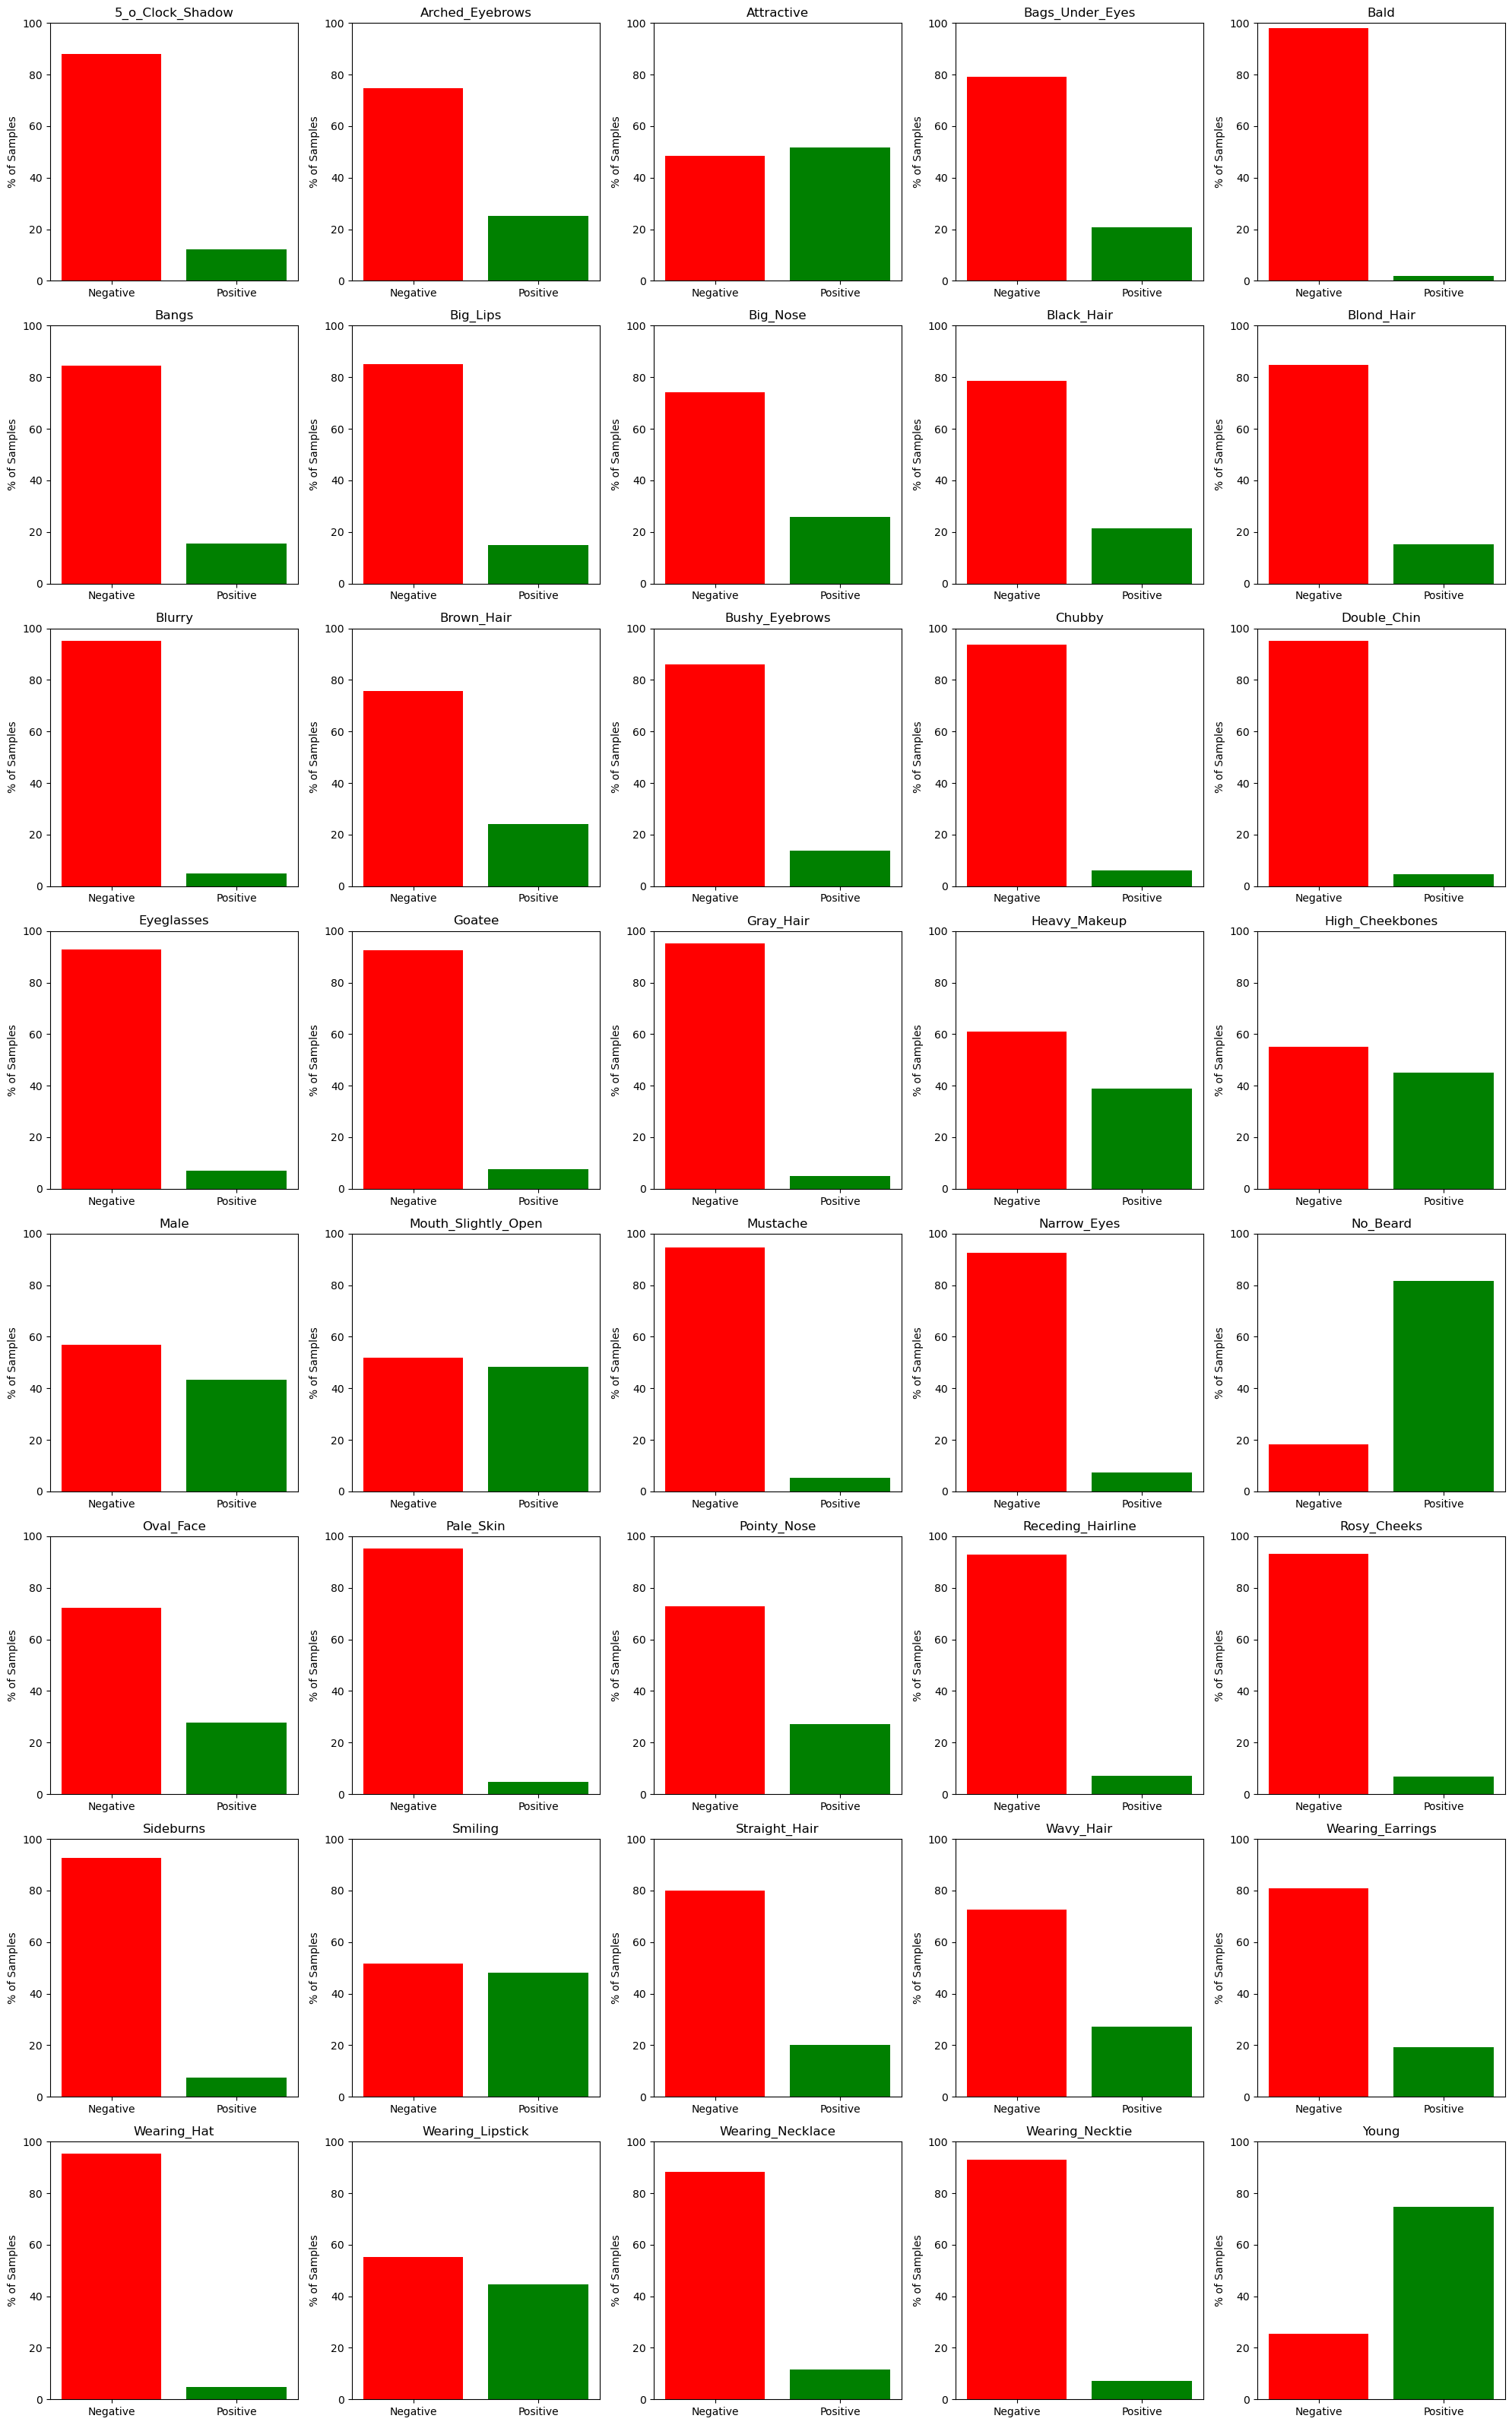

Class distribution in test dataset


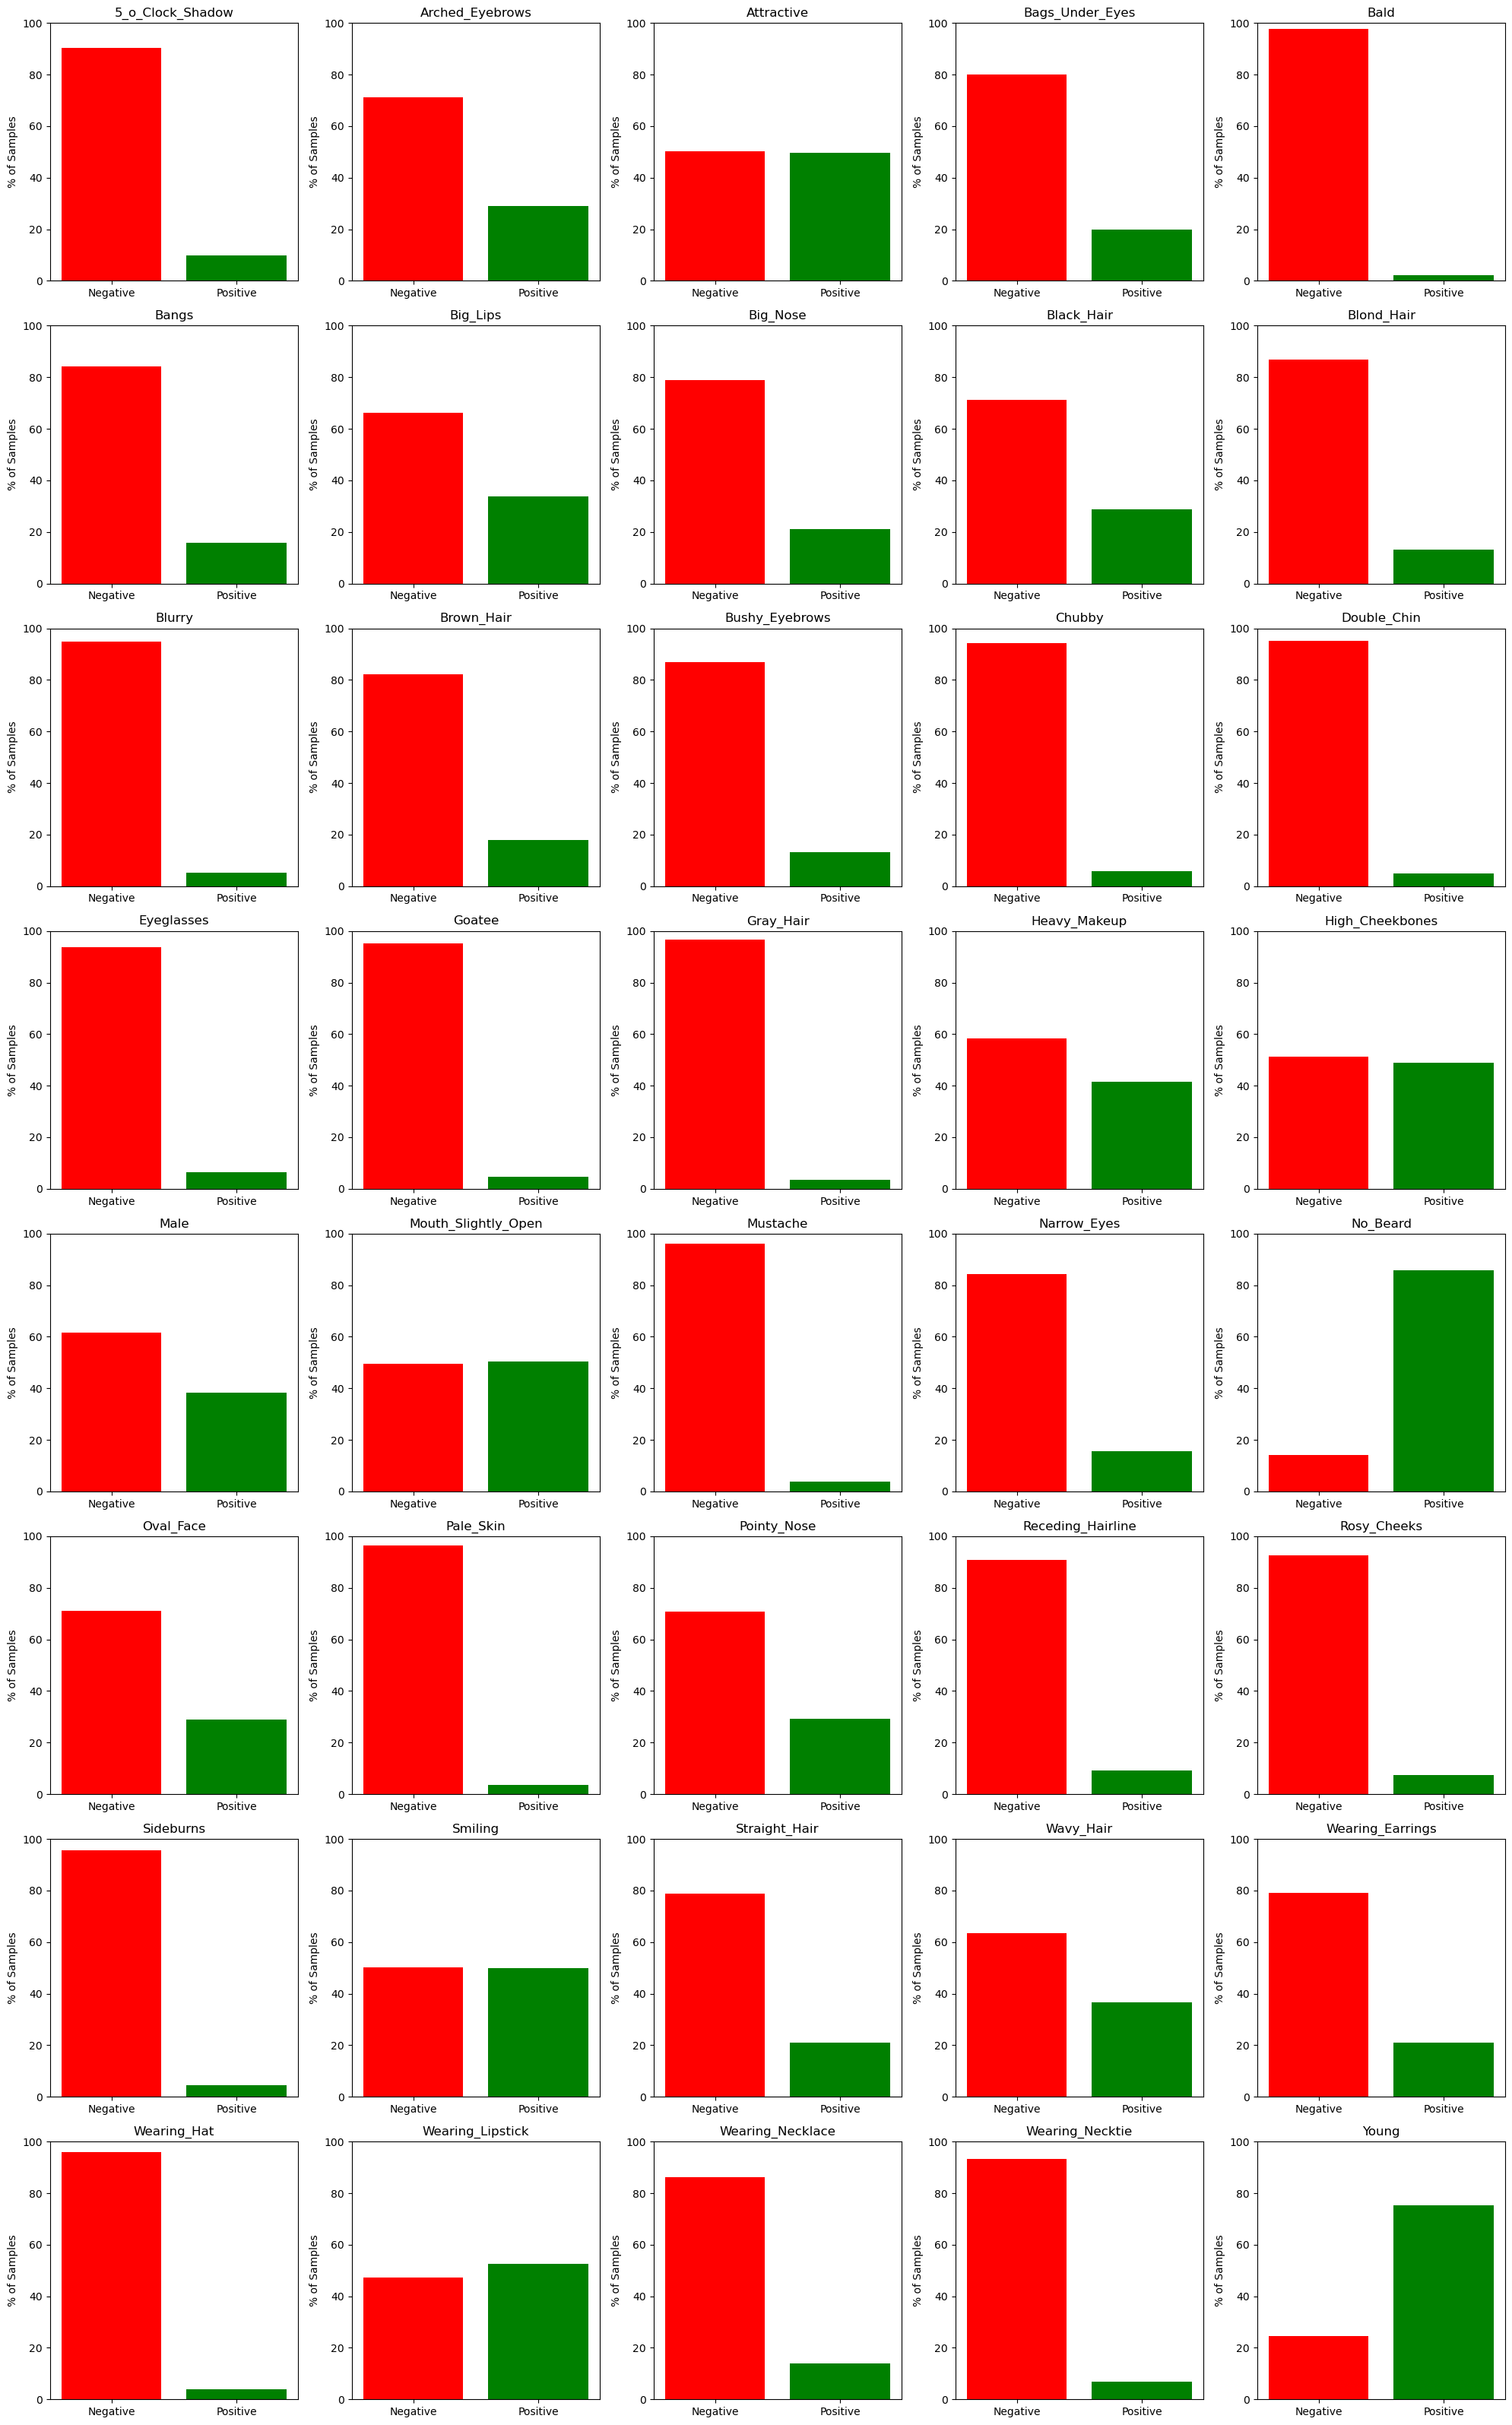

In [34]:
feature_columns = dataset.columns.tolist()
feature_columns.remove('image_id')

print("Class distribution in train dataset")
plot_label_distribution(train_percentages, feature_columns)
print("Class distribution in validation dataset")
plot_label_distribution(validation_percentages, feature_columns)
print("Class distribution in test dataset")
plot_label_distribution(test_percentages, feature_columns)